# Où sont les ménages défavorisés ?

In [117]:
!pip install -q -q -q geopandas
!pip install -q -q -q py7zr
!pip install -q -q -q btbpy
!pip install -q -q -q mapclassify
!pip install -q -q -q contextily

In [123]:
import os
import urllib.request
import shutil
from py7zr import unpack_7zarchive

import pandas as pd
import geopandas as gpd
import btbpy as btb
import contextily as cx

Load the whole french grid (1km)

In [16]:
chem_data_dir = os.path.join(os.path.dirname(btb.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid) #the grid

Load French communes and create departement and region layers

In [38]:
shutil.unpack_archive('commune_francemetro_2020_simplify.zip')

In [42]:
commune = gpd.read_file('commune_francemetro_2020.shp')

In [46]:
departement = commune.dissolve('dep', as_index=False)
region = commune.dissolve('reg', as_index=False)

Download and load the french data grid

In [5]:
url = 'https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_shp.zip'
urllib.request.urlretrieve(url, 'sdf.zip')
shutil.unpack_archive('sdf.zip')
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('Filosofi2015_carreaux_200m_metropole_shp.7z', '')

In [6]:
sdf = gpd.read_file('Filosofi2015_carreaux_200m_metropole.shp')

In [20]:
Men = sdf[['IdINSPIRE','geometry', 'Depcom', 'Men', 'Men_pauv']].copy()
Men['x'] = Men.geometry.centroid.x
Men['y'] = Men.geometry.centroid.y

## Analyse classique 

Dans cette première partie, on explore la répartion des ménages pauvres à l'aide d'un ratio relativement naturel : la part des ménages pauvre parmi l'ensemble des ménages. Les données carroyées sont par construction lacunaire. Il est préférable d'utiliser un lissage spatiale pour faire ressortir l'informartion pertinente.

### France entière

In [25]:
liss_france = btb.kernelSmoothing(Men[['Men', 'Men_pauv', 'x', 'y']], '2154', 1000, 20000, fr_1km,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [72]:
liss_france['ratio_pauvre'] = liss_france.Men_pauv / liss_france.Men * 100

Text(0.5, 1, 'Part des ménages Pauvres (Filosofi 2015) - Rayon de lissage = 20000')

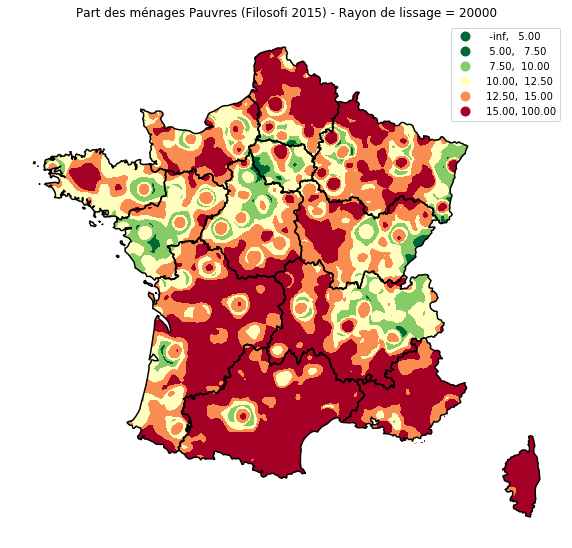

In [133]:
bins = [5, 7.5, 10, 12.5, 15, 100]
ax = liss_france.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True )
region.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_title('Part des ménages Pauvres (Filosofi 2015) - Rayon de lissage = 20000')

### Paris et sa banlieue

In [74]:
Men_Paris = Men.cx[(651935.49-60000):(651935.49+60000),(6862339.24-60000):(6862339.24+60000)]

In [91]:
liss_Paris_extra = btb.kernelSmoothing(Men_Paris[['Men', 'Men_pauv', 'x', 'y']], '2154', 500, 5000,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [92]:
liss_Paris_extra['ratio_pauvre'] = liss_Paris_extra.Men_pauv / liss_Paris_extra.Men * 100

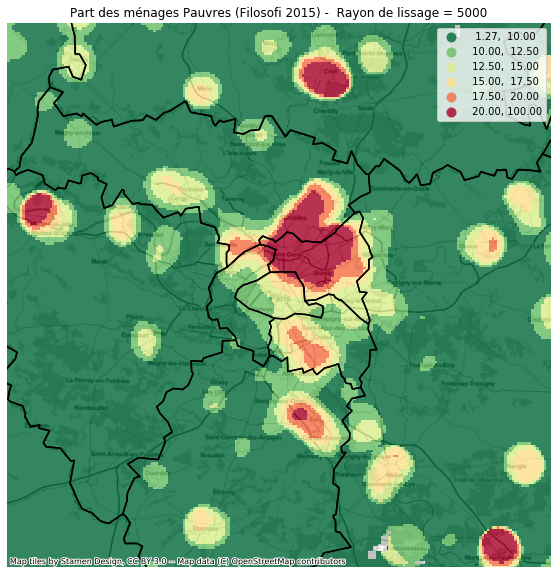

In [132]:
bins = [10, 12.5, 15, 17.5, 20, 100]
ax = liss_Paris_extra.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True,
                      alpha=0.8)
departement.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_xlim((651935-55000, 651935+55000))
ax.set_ylim((6862339-55000, 6862339+55000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 5000')
cx.add_basemap(ax, crs=liss_Paris_extra.crs.to_string(),source=cx.providers.Stamen.Toner)

### Paris

In [112]:
Men_Paris_intra = Men_Paris.cx[(651935.49-20000):(651935.49+20000),(6862339.24-20000):(6862339.24+20000)]

In [113]:
liss_Paris_intra = btb.kernelSmoothing(Men_Paris_intra[['Men', 'Men_pauv', 'x', 'y']], '2154', 100, 400,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [114]:
liss_Paris_intra['ratio_pauvre'] = liss_Paris_intra.Men_pauv / liss_Paris_intra.Men * 100

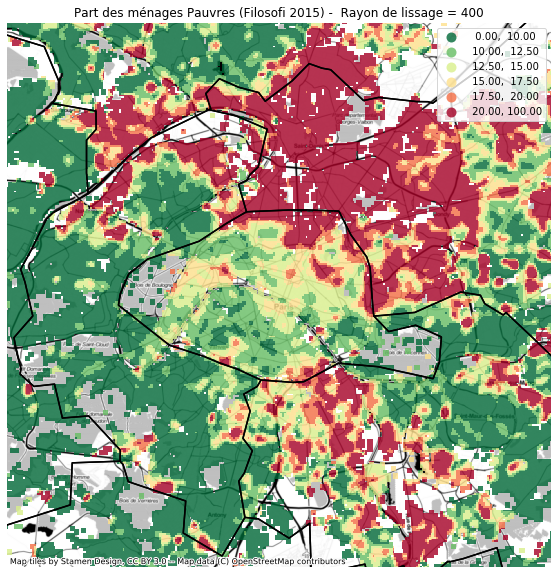

In [131]:
bins = [10, 12.5, 15, 17.5, 20, 100]
ax = liss_Paris_intra.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True, 
                      alpha=0.8)
departement.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_xlim((651935-15000, 651935+15000))
ax.set_ylim((6862339-15000, 6862339+15000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 400')
cx.add_basemap(ax, crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)

## Analyse en dense (Volume)

Avec des représentations en carte de densité,  la répartition des ménages pauvres est tout autre. 

Text(0.5, 1, 'Densité de ménages Pauvres (Filosofi 2015) - Bandwidth = 20000')

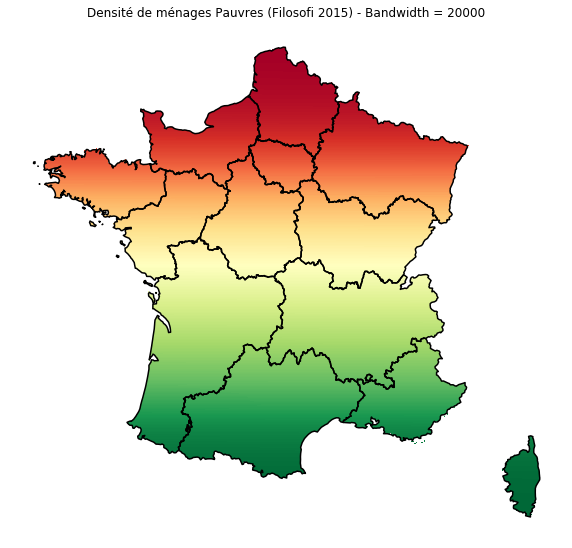

In [135]:
bins = [0, 5, 10, 15, 20, 100]
ax = liss_france.plot('Men_pauv',
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True )
region.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_title('Densité de ménages Pauvres (Filosofi 2015) - Bandwidth = 20000')

In [ ]:
liss_Paris_extra.Men_pauv = liss_Paris_extra.Men_pauv * 4

In [ ]:
bins = [10, 20, 30, 40, 50, 100]
ax = liss_Paris_extra.plot('Men_pauv', 
                      scheme = 'Quantiles',     
                      #scheme='user_defined', 
                      #classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True,
                      alpha=0.8)
departement.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_xlim((651935-55000, 651935+55000))
ax.set_ylim((6862339-55000, 6862339+55000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 5000')
cx.add_basemap(ax, crs=liss_Paris_extra.crs.to_string(),source=cx.providers.Stamen.Toner)